<a href="https://colab.research.google.com/github/3x10e8/L2S/blob/main/getting_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation Flow
In this example, we will work through the process of defining a neural network and generating the intermediate files needed to run this network on custom hardware.

We will use numpy arrays to define the following:
- Connectivity matrix
- External inputs (axon) weights
- Input stimuli

Then we will sanity check the generated intermediate files by running them through a python simulator.


# Environment Setup
We begin by cloning a github repo containing helper functions for running simulations and generating the intermediate files.

In [1]:
# Clone examples repo to colab server
! git clone https://github.com/3x10e8/L2S.git

fatal: destination path 'L2S' already exists and is not an empty directory.


In [2]:
import os
import sys
sys.path.insert(0, os.getcwd() + '/L2S')
from L2S.intermediate_format import *
from L2S.simple_sim import *

import numpy as np
import matplotlib.pyplot as plt

# Network Connectivity
For this example, let's consider the following network consisting of two neurons and one external input (axon):

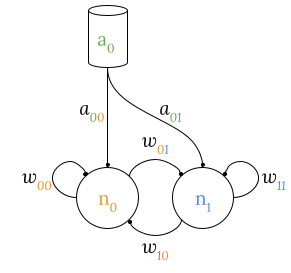



In [3]:
N = 2 # number of neurons, represented as n0 and n1 above
M = 1 # number of external inputs (axons), represented as a0

## Synaptic Weights
We first define the weights $w_{ij}$ for the inter- and intra-neural connections:

$
W = \begin{pmatrix}
w_{00} & w_{01}\\
w_{10} & w_{11}
\end{pmatrix}
$

Synaptic weights are defined here as floats where:
- positive values are excitatory, 
- negative values are inhibitory, and 
- zeros represent no-connects.

In [13]:
W = np.zeros(shape=(N, N), dtype=float)
W[0][0] = 0     # autapse
W[0][1] = 0.5   # synapse
W[1][0] = 0     # synapse
W[1][1] = 0     # autapse

print('Connectivity martix:')
print(W)
#plt.imshow(W)  # for visualizing bigger matrices

Connectivity martix:
[[0.  0.5]
 [0.  0. ]]


## External Input (Axon) Weights
Next we define the external inputs to this network as axons:

$
A = \begin{pmatrix}
a_{00} & a_{01}
\end{pmatrix}
$

In [14]:
A = np.zeros(shape=(M, N), dtype=float)
A[0][0] = 0.7
A[0][1] = 0

print('Axon weights:')
print(A)

Axon weights:
[[0.7 0. ]]


# Input Stimuli
Now with our network connections defined, we define inputs to the network as  time series currents coming in over each axon:


[[0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


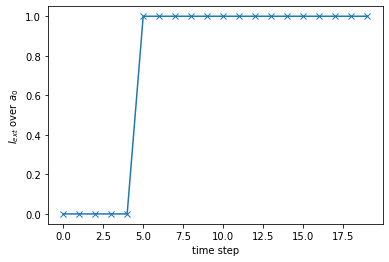

In [30]:
# Spikes inputs over time
num_steps = 20
Iext = np.zeros(shape=(M, num_steps))
Iext[0][5:] = 1 # send spikes from t=5 to t=19

plt.plot(range(num_steps), Iext[0], 'x-')
plt.xlabel('time step')
plt.ylabel('$I_{ext}$ over $a_0$')
print(Iext)

# Generating Intermediate Files
We will generate three text files which can then be used on hardware, or simulated as explored below:
- connectivity file
- inputs file
- config file
- output file (placeholder)

## Connectivity (connex) File
This file captures synaptic and axon weights for our network:

In [32]:
# Generate connectivity file
connex_file_path = './test_connectivity_2.txt'
write_conn_file(A, W, opath = connex_file_path, print_to_screen = True)

Wrote connectivity file to: ./test_connectivity_2.txt
----- Wrote -----
Axons
0: [(0, 0.7)]
Neurons
0: [(1, 0.5)]
1: []


## Input File
This file describes which axons $a_i$ are active for each time step:

```
<time step>: [<index of driven axon>]
```


In [33]:
# Generate input file
write_input_file(Iext, opath = './test_inputs_2.txt',
                 print_to_screen = True)

Wrote input file to: ./test_inputs_2.txt
----- Wrote -----
0: []
1: []
2: []
3: []
4: []
5: [0]
6: [0]
7: [0]
8: [0]
9: [0]
10: [0]
11: [0]
12: [0]
13: [0]
14: [0]
15: [0]
16: [0]
17: [0]
18: [0]
19: [0]


# Output File


In [38]:
output_path = './out.txt'
with open(output_path, 'w') as f:
  f.write("") # this is just a placeholder file

## Config File

In [39]:
import yaml
config_path = r'./config.yaml' # path for writing out config.yaml

# Set config parameters
config = {}
#config['FPGA_cluster']
config['inputs_file'] = './test_inputs_2.txt'
config['connectivity_file'] = './test_connectivity_2.txt'
config['outputs_file'] = './out.txt'

config['neuron_type'] = "I&F"
config['global_neuron_params'] = {}
#config['global_neuron_params']['v_alpha']
config['global_neuron_params']['v_thr'] = 1
#config['global_neuron_params']['v_rst']
#config['run_time']
#config['n_ng']
#config['ptrs_per_row']
#config['data_per_row']

# Write out updated config
with open(config_path, 'w') as f:
  yaml.dump(config, f)

# Readback and print contents
with open(config_path) as f:
    config = yaml.load(f)
    #print(config)

for key in config:
  print(key + ':\t', config[key])

connectivity_file:	 ./test_connectivity_2.txt
global_neuron_params:	 {'v_thr': 1}
inputs_file:	 ./test_inputs_2.txt
neuron_type:	 I&F
outputs_file:	 ./out.txt


# Simulate

In [41]:
axons, connections, inputs, outputs = load_network(
    input='./test_inputs_2.txt', 
    connex='./test_connectivity_2.txt', 
    output='./out.txt')

simulate(3, 1, axons, connections, inputs, outputs)
print("____________")
run_sim()

0 []
0 Vmem [0. 0.]
1 []
1 Vmem [0. 0.]
2 []
2 Vmem [0. 0.]
3 []
3 Vmem [0. 0.]
4 []
4 Vmem [0. 0.]
5 []
5 Vmem [0.7 0. ]
6 []
6 Vmem [1.4 0. ]
7 [0]
7 Vmem [0.7 0.5]
8 []
8 Vmem [1.4 0.5]
9 [0]
9 Vmem [0.7 1. ]
10 []
10 Vmem [1.4 1. ]
11 [0]
11 Vmem [0.7 1.5]
12 [1]
12 Vmem [1.4 0. ]
13 [0]
13 Vmem [0.7 0.5]
14 []
14 Vmem [1.4 0.5]
15 [0]
15 Vmem [0.7 1. ]
16 []
16 Vmem [1.4 1. ]
17 [0]
17 Vmem [0.7 1.5]
18 [1]
18 Vmem [1.4 0. ]
19 [0]
19 Vmem [0.7 0.5]
____________
0 []
0 Vmem [0. 0.]
1 []
1 Vmem [0. 0.]
2 []
2 Vmem [0. 0.]
3 []
3 Vmem [0. 0.]
4 []
4 Vmem [0. 0.]
5 []
5 Vmem [0.7 0. ]
6 []
6 Vmem [1.4 0. ]
7 [0]
7 Vmem [0.7 0.5]
8 []
8 Vmem [1.4 0.5]
9 [0]
9 Vmem [0.7 1. ]
10 []
10 Vmem [1.4 1. ]
11 [0]
11 Vmem [0.7 1.5]
12 [1]
12 Vmem [1.4 0. ]
13 [0]
13 Vmem [0.7 0.5]
14 []
14 Vmem [1.4 0.5]
15 [0]
15 Vmem [0.7 1. ]
16 []
16 Vmem [1.4 1. ]
17 [0]
17 Vmem [0.7 1.5]
18 [1]
18 Vmem [1.4 0. ]
19 [0]
19 Vmem [0.7 0.5]
